# Transfer Learning

---

#### Goals

1. load pre-trained model (ResNet)
2. choose layers for fine-tuning
3. Learn CIFAR-10 using your transfer learning model

---

## 1. Library Importation & Device Preparation

In [1]:
# You don't need to edit this section today.
import gc
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from IPython.display import clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torchsummary import summary as Summary
from torchvision import models
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize, RandomCrop, RandomHorizontalFlip, \
                                   ToPILImage, Resize, Grayscale

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{"CPU" if device == "cpu" else "GPU"} will be used in training/validation.')

GPU will be used in training/validation.


## 2. Hyper-parameters

By executing below blocks, you can initialize/update hyper-parameters.

In [2]:
# Data Load
input_norm_mean = (.4914, .4822, .4465)
input_norm_std = (.2023, .1994, .2010)
batch_size = 16

# Learning
logging_dispfig = True
maximum_epoch = 15
learning_rate = 1e-3

## 3. Data Load & Preprocessing

Today we will use CIFAR-10 dataset with data augmentation.

![CIFAR-10 examples](https://monet.postech.ac.kr/~wldh/CIFAR10.svg)

In [3]:
# Load dataset into python variable
input_transform = transforms.Compose([
  Resize(224),
  RandomCrop(224, padding=24),
  RandomHorizontalFlip(),
  ToTensor(),
  Normalize(mean=input_norm_mean, std=input_norm_std),
])

train_data = CIFAR10("./", train=True, transform=input_transform, download=True)
train_data, valid_data = random_split(train_data, [45000, 5000])
test_data = CIFAR10("./", train=False, transform=input_transform, download=False)

1.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

4.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

7.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

9.8%IOPub mes

74.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

76.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

81.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

84.5%IOPub

Extracting ./cifar-10-python.tar.gz to ./


In [4]:
# In order to see the power of transfer learning, let the size of data by 1/10

def minimize(num):
    mini = []
    for data in train_data:
        mini.append(data)
        num -= 1
        if num == 0: break
    return mini        
    
train_data_mini = minimize(4500)
valid_data_mini = minimize(500)
test_data_mini = minimize(1000)

Train dataset length = 4500
Valid dataset length = 500
Test dataset length = 1000

Classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Label (int) = 2 (bird)
Data (Tensor) = torch.Size([3, 224, 224])



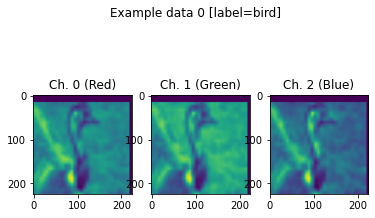

In [5]:
# Check the data
print(f'Train dataset length = {len(train_data_mini)}')
print(f'Valid dataset length = {len(valid_data_mini)}')
print(f'Test dataset length = {len(test_data_mini)}\n')

print(f'Classes = {test_data.classes}\n')

train_0_x, train_0_y = train_data_mini[0]
print(f'Label ({type(train_0_y).__name__}) = {train_0_y} ({test_data.classes[train_0_y]})')
print(f'Data ({type(train_0_x).__name__}) = {train_0_x.shape}\n')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Example data 0 [label={test_data.classes[train_0_y]}]')
ax1.imshow(train_0_x[0, :, :])
ax1.set_title('Ch. 0 (Red)')
ax2.imshow(train_0_x[1, :, :])
ax2.set_title('Ch. 1 (Green)')
ax3.imshow(train_0_x[2, :, :])
ax3.set_title('Ch. 2 (Blue)')
plt.show()

In [6]:
# Create data loader
train_loader = DataLoader(train_data_mini, batch_size=batch_size, shuffle=True, pin_memory=True,
                          drop_last=True)
valid_loader = DataLoader(valid_data_mini, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_data_mini, batch_size=batch_size, pin_memory=True)

Idx: 0 / X.shape = torch.Size([16, 3, 224, 224]) / Y.shape = torch.Size([16])

Y[0:16] = [6, 1, 5, 2, 5, 3, 7, 3, 8, 7, 1, 8, 8, 8, 4, 6]
→ Label = ['frog' 'automobile' 'dog' 'bird' 'dog' 'cat' 'horse' 'cat' 'ship' 'horse'
 'automobile' 'ship' 'ship' 'ship' 'deer' 'frog']



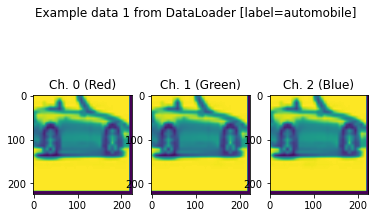

In [7]:
# Examine the data loader
train_enumerator = enumerate(train_loader)
ex_batch_idx, (ex_data, ex_label) = next(train_enumerator)
print(f'Idx: {ex_batch_idx} / X.shape = {ex_data.shape} / Y.shape = {ex_label.shape}\n')
print(f'Y[0:{batch_size}] = {ex_label.tolist()}')
print(f'→ Label = {np.array(test_data.classes)[ex_label]}\n')

preview_index = 1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Example data {preview_index} from DataLoader [label={test_data.classes[ex_label[preview_index]]}]')
ax1.imshow(ex_data[preview_index, 0, :, :])
ax1.set_title('Ch. 0 (Red)')
ax2.imshow(ex_data[preview_index, 1, :, :])
ax2.set_title('Ch. 1 (Green)')
ax3.imshow(ex_data[preview_index, 2, :, :])
ax3.set_title('Ch. 2 (Blue)')
plt.show()

## 4. Function Definitions

Because our model is too simple now, we will use just `nn.Linear` module and wrap it with initializer function instead of defining a model class.

In [8]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Model structure check
Summary(models.resnet18(pretrained = True).to(device), (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/piai/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
52.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

-  freeze

In [ ]:
# net = models.resnet18(pretrained=True)
# # freeze -> gradient x
# for param in net.parameters():
#     param.requires_grad=False
    
# # class
# # net.fc = nn.Linear(512, 10) #nn.Linear(in, out)
# in_features=net.fc.in_features
# net.fc = nn.Linear(in_features, 10)

In [10]:
# Model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def init_model(model_name, num_classes, feature_extract, use_pretrained=True):
    global net, loss_fn, optim
    
    # get CNN model from PyTorch Model Zoo
    if model_name == "resnet":
        """ Resnet18
        """
        net = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        # Parameters of newly constructed modules have requires_grad=True by default
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        net = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        net = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier[6].in_features
        net.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        net = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        net.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        net = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        num_ftrs = net.classifier.in_features
        net.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        net = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(net, feature_extract)
        # Handle the auxilary net
        num_ftrs = net.AuxLogits.fc.in_features
        net.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = net.fc.in_features
        net.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Choose Model between [resnet, alexnet, vgg, squeezenet, densenet, inception]")
        return 
    
    net = net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate)

    return input_size

In [11]:
# Memory cleaner to prevent CUDA out of memory error
def clear_memory():
    if device != 'cpu':
        empty_cache()
    garb_collected = gc.collect()

In [12]:
# Epoch
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0


def epoch(data_loader):
    # One epoch : gets data_loader as input and returns loss / accuracy, and
    #             last prediction value / its label(truth) value for future use
    global epoch_cnt
    iter_loss, iter_acc = [], []

    last_grad_performed = False

    # Mini-batch iterations
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)

        # 1. Feed-forward
        onehot_out = net(data)

        # 2. Calculate accuracy
        _, out = torch.max(onehot_out, 1)
        acc_partial = (out == label).float().sum()
        acc_partial = acc_partial / len(label)
        iter_acc.append(acc_partial.item())

        # 3. Calculate loss
        loss = loss_fn(onehot_out, label)
        iter_loss.append(loss.item())

        # 4. Backward propagation if not in `torch.no_grad()`
        if onehot_out.requires_grad:
            optim.zero_grad()
            loss.backward()
            optim.step()
            last_grad_performed = True

    # Up epoch count if backward propagation is done
    if last_grad_performed:
        epoch_cnt += 1

    # Clear memory to prevent CUDA memory error
    clear_memory()
    
    return np.average(iter_loss), np.average(iter_acc)


def epoch_not_finished():
    # For now, let's repeat training fixed times, e.g. 25 times.
    # We will learn how to determine training stop or continue later.
    return epoch_cnt < maximum_epoch

In [13]:
# Logging
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []


def record_train_log(_tloss, _tacc, _time):
    # Push time, training loss, training accuracy, and epoch count into lists
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)


def record_valid_log(_vloss, _vacc):
    # Push validation loss and validation accuracy into each list
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)


def last(log_list):
    # Get the last member of list. If empty, return -1.
    if len(log_list) > 0: return log_list[len(log_list) - 1]
    else: return -1


def print_log():
    # Generate log string and put it into log stack
    log_str = f'Iter: {last(iter_log):>4d} >> T_loss {last(tloss_log):<8.5f}   ' \
          + f'T_acc {last(tacc_log):<6.5f}   V_loss {last(vloss_log):<8.5f}   ' \
          + f'V_acc {last(vacc_log):<6.5f}   🕒 {last(time_log):5.3f}s'
    log_stack.append(log_str)

    # Draw figure if want
    if logging_dispfig:
        hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
        hist_fig.patch.set_facecolor('white')

        # Draw loss lines
        loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='#FF9999', marker='o')
        loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='#99B0FF', marker='s')
        loss_axis.set_xlabel('epoch')
        loss_axis.set_ylabel('loss')

        # Draw accuracy lines
        acc_axis = loss_axis.twinx()
        acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='#FF0000', marker='+')
        acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='#003AFF', marker='x')
        acc_axis.set_ylabel('accuracy')

        # Append annotations
        hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
        loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
        loss_axis.grid()
        plt.title(f'Learning history until epoch {last(iter_log)}')
        plt.draw()

    # Print log
    clear_output(wait=True)
    if logging_dispfig: plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

## 5. Training Iteration & Result Analysis (Train the entire model)

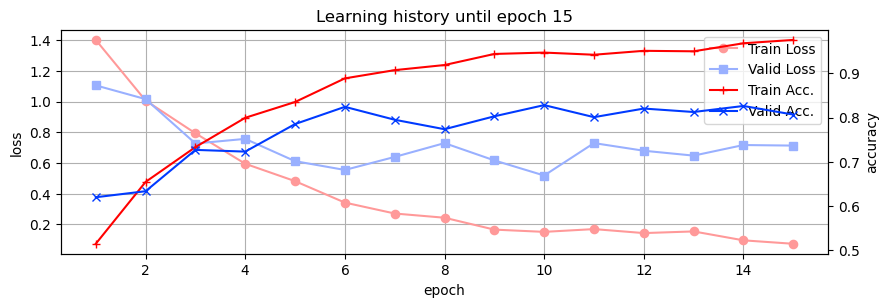

Iter:   15 >> T_loss 0.07293    T_acc 0.97598   V_loss 0.71307    V_acc 0.80664   🕒 9.086s
Iter:   14 >> T_loss 0.09539    T_acc 0.96842   V_loss 0.71674    V_acc 0.82617   🕒 9.120s
Iter:   13 >> T_loss 0.15351    T_acc 0.95018   V_loss 0.64767    V_acc 0.81250   🕒 9.056s
Iter:   12 >> T_loss 0.14266    T_acc 0.95129   V_loss 0.67956    V_acc 0.82031   🕒 9.062s
Iter:   11 >> T_loss 0.16867    T_acc 0.94239   V_loss 0.72935    V_acc 0.80078   🕒 9.097s
Iter:   10 >> T_loss 0.15057    T_acc 0.94729   V_loss 0.51795    V_acc 0.82812   🕒 9.049s
Iter:    9 >> T_loss 0.16528    T_acc 0.94417   V_loss 0.61657    V_acc 0.80273   🕒 9.029s
Iter:    8 >> T_loss 0.24278    T_acc 0.91904   V_loss 0.72924    V_acc 0.77344   🕒 9.018s
Iter:    7 >> T_loss 0.27029    T_acc 0.90747   V_loss 0.63916    V_acc 0.79492   🕒 9.052s
Iter:    6 >> T_loss 0.34143    T_acc 0.88879   V_loss 0.55427    V_acc 0.82422   🕒 9.014s
Iter:    5 >> T_loss 0.48128    T_acc 0.83519   V_loss 0.61155    V_acc 0.78516   🕒 9.020s

In [14]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=False, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    net.eval()
    test_loss, test_acc = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')

## 6. Training Iteration & Result Analysis (Freeze the convlutional base)

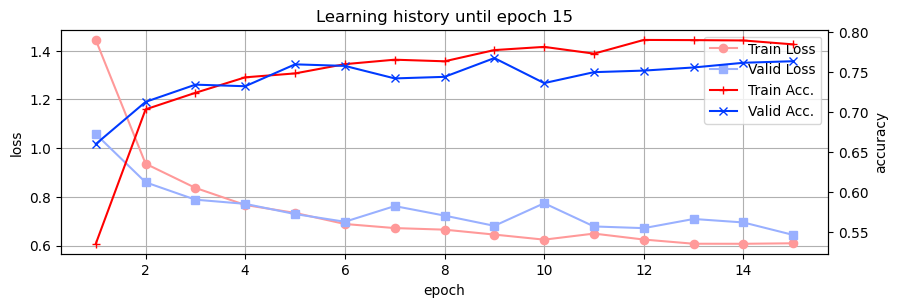

Iter:   15 >> T_loss 0.60912    T_acc 0.78470   V_loss 0.64333    V_acc 0.76367   🕒 3.411s
Iter:   14 >> T_loss 0.60708    T_acc 0.78959   V_loss 0.69468    V_acc 0.76172   🕒 3.477s
Iter:   13 >> T_loss 0.60728    T_acc 0.79004   V_loss 0.70902    V_acc 0.75586   🕒 3.555s
Iter:   12 >> T_loss 0.62448    T_acc 0.79026   V_loss 0.67135    V_acc 0.75195   🕒 3.475s
Iter:   11 >> T_loss 0.64896    T_acc 0.77313   V_loss 0.67827    V_acc 0.75000   🕒 3.546s
Iter:   10 >> T_loss 0.62408    T_acc 0.78158   V_loss 0.77375    V_acc 0.73633   🕒 3.483s
Iter:    9 >> T_loss 0.64489    T_acc 0.77758   V_loss 0.68080    V_acc 0.76758   🕒 3.538s
Iter:    8 >> T_loss 0.66513    T_acc 0.76357   V_loss 0.72288    V_acc 0.74414   🕒 3.578s
Iter:    7 >> T_loss 0.67162    T_acc 0.76557   V_loss 0.76199    V_acc 0.74219   🕒 3.575s
Iter:    6 >> T_loss 0.68837    T_acc 0.76001   V_loss 0.69762    V_acc 0.75781   🕒 3.385s
Iter:    5 >> T_loss 0.73393    T_acc 0.74844   V_loss 0.72919    V_acc 0.75977   🕒 3.391s

In [15]:
# Training Initialization
init_model(model_name='resnet', num_classes=10, feature_extract=True, use_pretrained=True)
init_epoch()
init_log()

# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader)
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(valid_loader)
        record_valid_log(vloss, vacc)
    print_log()

print('\n Training completed!')

# Accuracy for test dataset
with torch.no_grad():
    net.eval()
    test_loss, test_acc = epoch(test_loader)
    print('\n====================== Test Result ======================\n')
    print(f'Test accuracy = {test_acc}\nTest loss = {test_loss}')